In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices)!=0: #Use GPU for better experience
  tf.config.experimental.set_memory_growth(physical_devices[0],True)
print(physical_devices)

[]


In [ ]:
(x_train,y_train), (x_test,y_test) = mnist.load_data()
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


Kiểm tra xem tập train có bị bias không

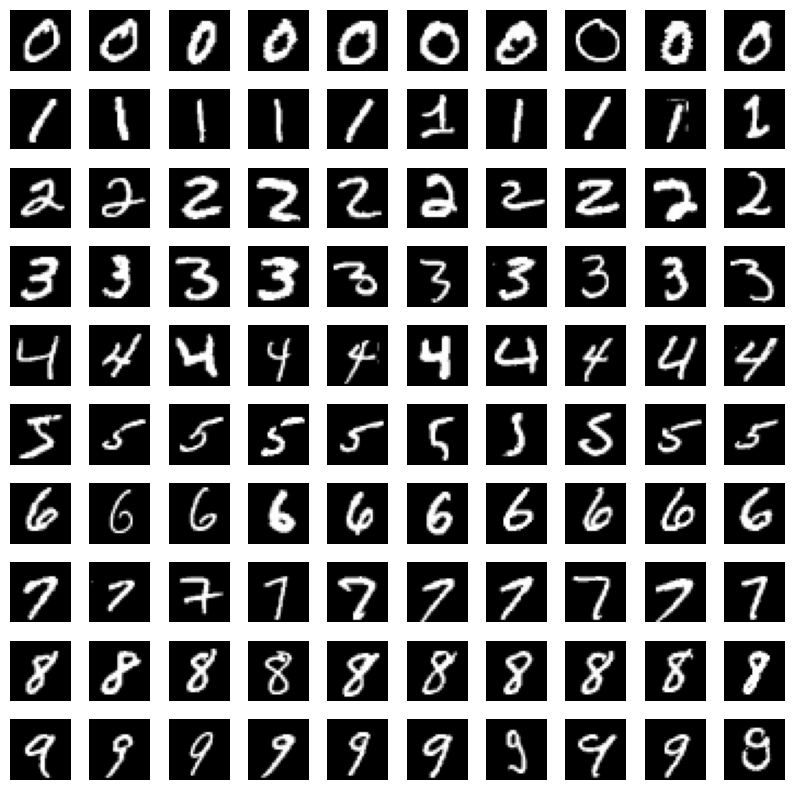

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for label in range(10):
    indices = np.where(y_train == label)[0][:10]
    for i, idx in enumerate(indices):
        ax = axes[label, i]
        ax.imshow(x_train[idx], cmap='gray')
        ax.axis('off')

plt.show()

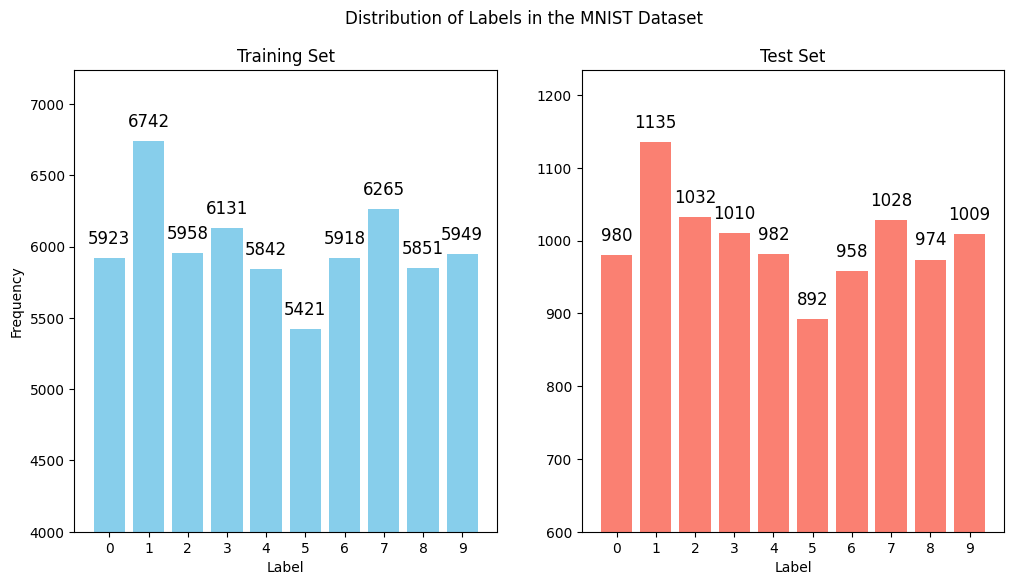

In [ ]:
train_label_counts = np.bincount(y_train, minlength=10)
test_label_counts = np.bincount(y_test, minlength=10)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Distribution of Labels in the MNIST Dataset')

ax[0].bar(range(10), train_label_counts, color='skyblue')
ax[0].set_xlabel('Label')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Training Set')
ax[0].set_xticks(range(10))
ax[0].set_ylim(4000, max(train_label_counts) + 500)
for i, count in enumerate(train_label_counts):
    ax[0].text(i, count + 100, str(count), ha='center', color='black', fontsize=12)

ax[1].bar(range(10), test_label_counts, color='salmon')
ax[1].set_xlabel('Label')
ax[1].set_title('Test Set')
ax[1].set_xticks(range(10))
ax[1].set_ylim(600, max(test_label_counts) + 100)
for i, count in enumerate(test_label_counts):
    ax[1].text(i, count + 20, str(count), ha='center', color='black', fontsize=12)

plt.show()

In [ ]:
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

In [ ]:
print(x_train.shape)
print(type(x_train))
print(max(x_train.flatten()),min(x_train.flatten()))
print(x_test.shape)
print(type(x_test))
print(max(x_test.flatten()),min(x_test.flatten()))

(60000, 28, 28)
<class 'numpy.ndarray'>
1.0 0.0
(10000, 28, 28)
<class 'numpy.ndarray'>
1.0 0.0


In [ ]:
from scipy.ndimage import rotate, gaussian_filter

#Rotation 30 deg maximum, just to make sure the labels wont mess up such as 9 and 6 or 2 and 5 or even 1 and 7
def random_rotate_image_2d(image, max_angle=30):
    angle = np.random.uniform(-max_angle, max_angle)
    rotated_image = rotate(image, angle, reshape=False, mode='nearest')
    return rotated_image

#Shift images horizontaly or vertically a few pixels
def shift_image(image, max_offset=3):
    offset_x = np.random.randint(-max_offset, max_offset + 1)
    offset_y = np.random.randint(-max_offset, max_offset + 1)
    return np.roll(np.roll(image.reshape(28, 28), offset_x, axis=1), offset_y, axis=0)

#Add gaussian noise
def add_gaussian_noise(image, mean=0,std=0.1):
    noise = np.random.normal(mean, std, image.shape)
    return np.clip(image + noise, 0, 1) #Remember to use with the normalized image pumpkin

def reduce_noise(image, sigma=0.5):
  return gaussian_filter(image, sigma=sigma)

def augment(image):
  image = random_rotate_image_2d(image)
  image = shift_image(image)
  image = add_gaussian_noise(image)
  image = reduce_noise(image)
  return image

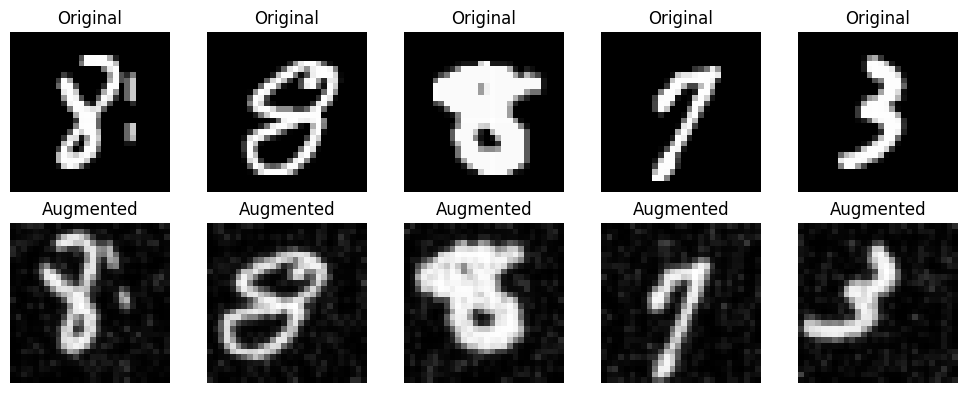

In [ ]:
num_images = 5

plt.figure(figsize=(10, 4))

for i in range(num_images):
    idx = np.random.randint(0, x_train.shape[0])
    original_image = x_train[idx]
    augmented_image = augment(original_image)

    plt.subplot(2, num_images, i + 1)
    plt.imshow(original_image, cmap='gray')
    plt.axis('off')
    plt.title("Original")

    plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(augmented_image, cmap='gray')
    plt.axis('off')
    plt.title("Augmented")

plt.tight_layout()
plt.show()

In [ ]:
x_train = np.array([augment(image) for image in x_train])

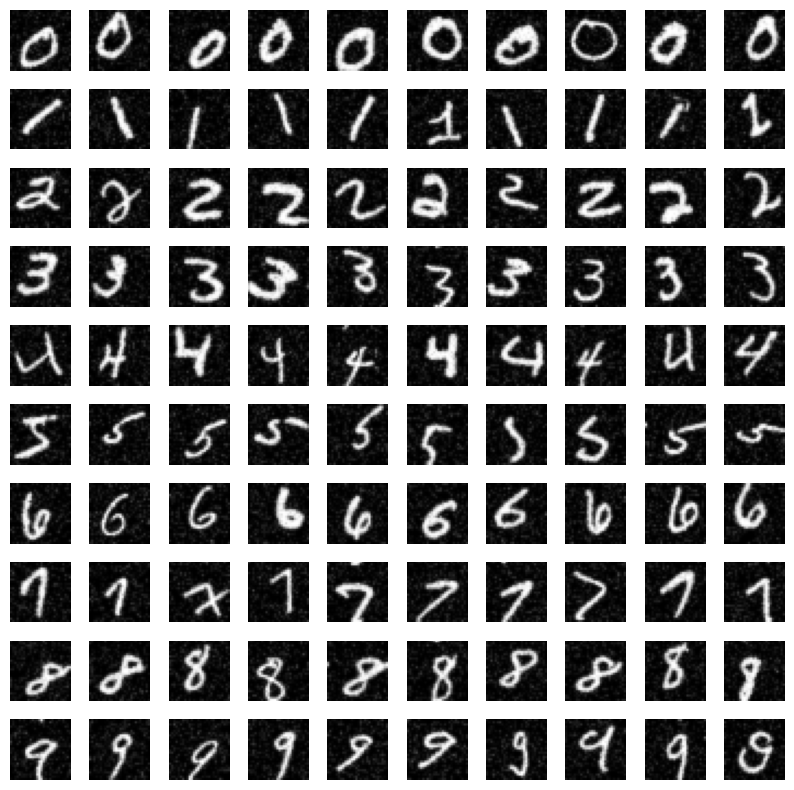

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for label in range(10):
    indices = np.where(y_train == label)[0][:10]
    for i, idx in enumerate(indices):
        ax = axes[label, i]
        ax.imshow(x_train[idx], cmap='gray')
        ax.axis('off')

plt.show()

In [ ]:
x_train = x_train.reshape(-1,28*28)
x_test = x_test.reshape(-1,28*28)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [ ]:
param_grid = {
    'learning_rate': [0.00001,0.0001,0.001],
    'hidden_size_layer1': [2,4,8,16,32,64],
    'hidden_size_layer2': [None],  # None để biểu thị không có lớp thứ hai
    'hidden_size_layer3': [None],  # None để biểu thị không có lớp thứ ba
    #lý do chọn tối đa đến tầng thứ 3 là tránh overfitting và sử dụng hàm sigmoid đạo hàm của nó max là 0.25 nếu có quá nhiều lớp ẩn gradient nhân dần với nhau sẽ tiến tới 0(hiện tượng vanishing gradient)
    'batch_size': [32, 64, 128],
    'weight_decay':[0.00001],
    'epochs': [5000]#vì dùng early stop nên cho một số epochs to hẳn
}

Cấu hình để thử từng trường hợp nhằm tìm ra chỉ số có accuracy tốt nhất

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


Tách tập train thành 2 tập là train và valid

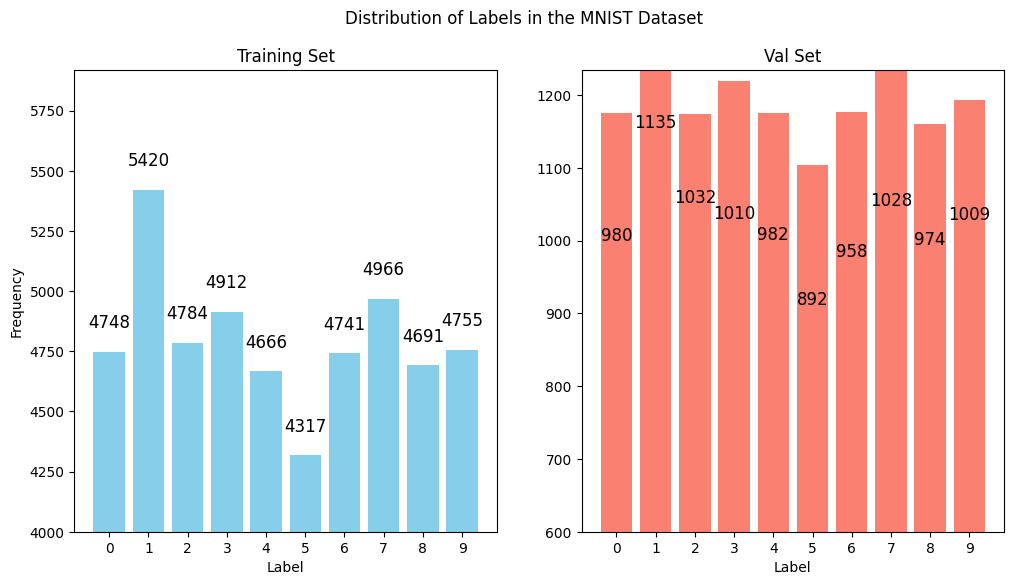

In [ ]:
train_label_counts = np.bincount(y_train, minlength=10)
val_label_counts = np.bincount(y_val, minlength=10)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Distribution of Labels in the MNIST Dataset')

ax[0].bar(range(10), train_label_counts, color='skyblue')
ax[0].set_xlabel('Label')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Training Set')
ax[0].set_xticks(range(10))
ax[0].set_ylim(4000, max(train_label_counts) + 500)
for i, count in enumerate(train_label_counts):
    ax[0].text(i, count + 100, str(count), ha='center', color='black', fontsize=12)

ax[1].bar(range(10), val_label_counts, color='salmon')
ax[1].set_xlabel('Label')
ax[1].set_title('Val Set')
ax[1].set_xticks(range(10))
ax[1].set_ylim(600, max(test_label_counts) + 100)
for i, count in enumerate(test_label_counts):
    ax[1].text(i, count + 20, str(count), ha='center', color='black', fontsize=12)

plt.show()

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(48000, 784)
(48000,)
(12000, 784)
(12000,)


In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
y_train_one_hot = encoder.fit_transform(y_train.reshape(-1, 1))
y_val_one_hot = encoder.transform(y_val.reshape(-1, 1))
y_test_one_hot = encoder.transform(y_test.reshape(-1, 1))

chuyển đổi mảng Y từ mảng 1 chiều sang mảng n chiều mỗi chiều có 10 phần tử tượng chưng cho 10 số (ví dụ số 0 là 1 0 0 0 ...,1 là 0 1 0 0 ...)

In [ ]:
print(y_train_one_hot.shape)
print(y_val_one_hot.shape)
print(y_test_one_hot.shape)

(48000, 10)
(12000, 10)
(10000, 10)


In [ ]:
import numpy as np

class SimpleNN:
    def __init__(self, input_size, hidden_size_layer1, hidden_size_layer2=None, hidden_size_layer3=None, output_size=1, learning_rate=0.01, l2_lambda=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.layers = []
        self.A_prev = []  # Dùng để lưu các kết quả
        self.l2_lambda = l2_lambda
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0  # Thời gian bước

        # Khởi tạo trọng số với Xavier Initialization
        self.layers.append(np.random.randn(input_size, hidden_size_layer1) * np.sqrt(2 / (input_size + hidden_size_layer1)))

        if hidden_size_layer2 is not None:
            self.layers.append(np.random.randn(hidden_size_layer1, hidden_size_layer2) * np.sqrt(2 / (hidden_size_layer1 + hidden_size_layer2)))

        if hidden_size_layer3 is not None:
            self.layers.append(np.random.randn(hidden_size_layer2 if hidden_size_layer2 is not None else hidden_size_layer1, hidden_size_layer3) * np.sqrt(2 / ((hidden_size_layer2 if hidden_size_layer2 is not None else hidden_size_layer1) + hidden_size_layer3)))

        self.W_output = np.random.randn((hidden_size_layer3 if hidden_size_layer3 is not None else (hidden_size_layer2 if hidden_size_layer2 is not None else hidden_size_layer1)), output_size) * np.sqrt(2 / ((hidden_size_layer3 if hidden_size_layer3 is not None else (hidden_size_layer2 if hidden_size_layer2 is not None else hidden_size_layer1)) + output_size))

        # Khởi tạo m và v cho Adam
        self.m_layers = [np.zeros_like(layer) for layer in self.layers]
        self.v_layers = [np.zeros_like(layer) for layer in self.layers]
        self.m_output = np.zeros_like(self.W_output)
        self.v_output = np.zeros_like(self.W_output)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, z):
        return z * (1 - z)

    def soft_max(self, z):
        z_max = np.max(z, axis=1, keepdims=True)
        e_z = np.exp(z - z_max)
        return e_z / np.sum(e_z, axis=1, keepdims=True)

    def loss_function(self, output, y):
        return -np.sum(y * np.log(output)) / y.shape[0] + self.l2_lambda * np.sum([np.sum(np.square(layer)) for layer in self.layers]) + self.l2_lambda * np.sum(np.square(self.W_output))

    def forward(self, X):
        self.A = X
        self.A_prev = []

        for W in self.layers:
            self.Z = np.dot(self.A, W)
            self.A = self.sigmoid(self.Z)
            self.A_prev.append(self.A)

        self.Z_output = np.dot(self.A, self.W_output)
        self.A_output = self.soft_max(self.Z_output)
        return self.A_output

    def backward(self, X, y):
        self.t += 1

        output_delta = self.A_output - y

        # Cập nhật trọng số đầu ra với Adam
        grad_output = self.A.T.dot(output_delta) + 2 * self.l2_lambda * self.W_output
        self.m_output = self.beta1 * self.m_output + (1 - self.beta1) * grad_output
        self.v_output = self.beta2 * self.v_output + (1 - self.beta2) * (grad_output ** 2)
        m_output_corr = self.m_output / (1 - self.beta1 ** self.t)
        v_output_corr = self.v_output / (1 - self.beta2 ** self.t)
        self.W_output -= self.learning_rate * m_output_corr / (np.sqrt(v_output_corr) + self.epsilon)

        hidden_delta = output_delta.dot(self.W_output.T) * self.sigmoid_derivative(self.A_prev[-1])

        for i in reversed(range(len(self.layers))):
            if i == 0:
                grad_hidden = X.T.dot(hidden_delta) + 2 * self.l2_lambda * self.layers[i]
            else:
                grad_hidden = self.A_prev[i - 1].T.dot(hidden_delta) + 2 * self.l2_lambda * self.layers[i]

            # Cập nhật trọng số với Adam
            self.m_layers[i] = self.beta1 * self.m_layers[i] + (1 - self.beta1) * grad_hidden
            self.v_layers[i] = self.beta2 * self.v_layers[i] + (1 - self.beta2) * (grad_hidden ** 2)
            m_corr = self.m_layers[i] / (1 - self.beta1 ** self.t)
            v_corr = self.v_layers[i] / (1 - self.beta2 ** self.t)
            self.layers[i] -= self.learning_rate * m_corr / (np.sqrt(v_corr) + self.epsilon)

            if i > 0:
                hidden_delta = hidden_delta.dot(self.layers[i].T) * self.sigmoid_derivative(self.A_prev[i - 1])

    def train(self, X, y, epochs):
        for epoch in range(epochs):
            self.forward(X)
            self.backward(X, y)

    def evaluate(self, X, y):
        output = self.forward(X)
        predictions = np.argmax(output, axis=1)
        true_labels = np.argmax(y, axis=1)
        accuracy = np.mean(predictions == true_labels)
        loss = self.loss_function(output, y)
        return accuracy, loss


Tạo mạng
+) công thức tính hàm cross-entropy(chưa phạt L2) và đạo hàm của hàm cross-entropy
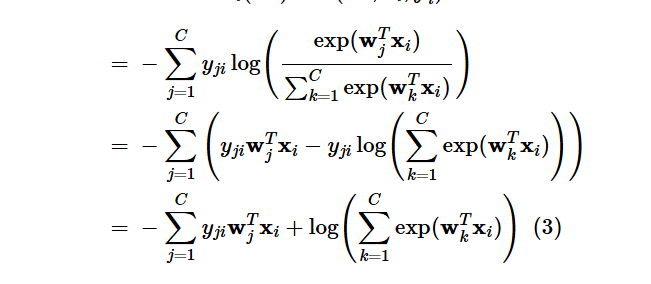
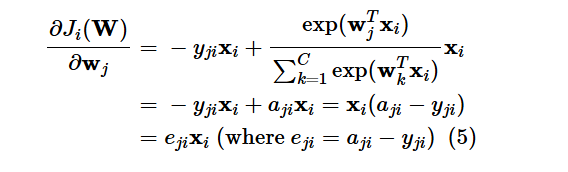

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(hidden_size_layer1, hidden_size_layer2, hidden_size_layer3, learning_rate, batch_size, x_train, y_train_one_hot, x_val, y_val_one_hot, epochs,weight_decay, patience=5, min_delta=0.001):
    model = SimpleNN(input_size=784,
                     hidden_size_layer1=hidden_size_layer1,
                     hidden_size_layer2=hidden_size_layer2,
                     hidden_size_layer3=hidden_size_layer3,
                     output_size=10,
                     learning_rate=learning_rate,
                     l2_lambda=weight_decay)
    best_accuracy = 0
    best_loss = float('inf')
    patience_counter = 0
    num_batches = int(np.ceil(len(x_train) / batch_size))

    for epoch in range(epochs):
        for i in range(num_batches):
            batch_x = x_train[i * batch_size:(i + 1) * batch_size]
            batch_y = y_train_one_hot[i * batch_size:(i + 1) * batch_size]
            model.train(batch_x, batch_y, 1)

        # Đánh giá độ chính xác và loss trên tập validation
        val_accuracy, val_loss = model.evaluate(x_val, y_val_one_hot)

        # Kiểm tra điều kiện early stopping
        if val_loss < best_loss - min_delta:
            best_loss = min(best_loss, val_loss)
            best_accuracy = max(best_accuracy, val_accuracy)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

        # Thông báo nếu loss đạt ngưỡng rất thấp
        if val_loss < 1e-8:
            print(f'Early stopping at epoch {epoch + 1} because loss_function is very low: {val_loss}')
            break

    # Đánh giá mô hình trên tập huấn luyện và tập xác thực
    train_accuracy, train_loss = model.evaluate(x_train, y_train_one_hot)
    val_accuracy, val_loss = model.evaluate(x_val, y_val_one_hot)

    # Dự đoán và tính các chỉ số trên tập huấn luyện và tập validation
    train_predictions = model.forward(x_train)
    val_predictions = model.forward(x_val)
    train_predictions_labels = np.argmax(train_predictions, axis=1)
    val_predictions_labels = np.argmax(val_predictions, axis=1)
    true_labels_train = np.argmax(y_train_one_hot, axis=1)
    true_labels_val = np.argmax(y_val_one_hot, axis=1)

    # Tính toán precision, recall, và F1-score
    precision = precision_score(true_labels_val, val_predictions_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels_val, val_predictions_labels, average='weighted')
    f1 = f1_score(true_labels_val, val_predictions_labels, average='weighted')

    return train_accuracy, val_accuracy, precision, recall, f1, train_loss, val_loss


xây dựng hàm đánh giá áp dụng early stop với patience là 5 tức là khi độ chính xác không tăng trong 5 lần liên tiếp sẽ lập tức dừng

# BẮT ĐẦU TÌM KIẾM HYPERPARAMS với một vài số ngẫu nhiên

In [ ]:
param_grid = {
    'learning_rate': [0.0001,0.001],
    'hidden_size_layer1': [2,4,8,16,32,64,128,256,512],
    'hidden_size_layer2': [None],  # None để biểu thị không có lớp thứ hai
    'hidden_size_layer3': [None],  # None để biểu thị không có lớp thứ ba
    #lý do chọn tối đa đến tầng thứ 3 là tránh overfitting và sử dụng hàm sigmoid đạo hàm của nó max là 0.25 nếu có quá nhiều lớp ẩn gradient nhân dần với nhau sẽ tiến tới 0(hiện tượng vanishing gradient)
    'batch_size': [32],
    'weight_decay':[0.00001,0.0001],
    'epochs': [5000]#vì dùng early stop nên cho một số epochs to hẳn
}
# Thử tất cả các kết hợp tham số
for learning_rate in param_grid['learning_rate']:
  for weight_decay in param_grid['weight_decay']:
    for hidden_size_layer3 in param_grid['hidden_size_layer3']:
        for hidden_size_layer2 in param_grid['hidden_size_layer2']:
            for hidden_size_layer1 in param_grid['hidden_size_layer1']:
                for batch_size in param_grid['batch_size']:
                    for epochs in param_grid['epochs']:
                        train_accuracy, val_accuracy, precision, recall, f1,loss_train,loss_val = evaluate_model(
                            hidden_size_layer1,
                            hidden_size_layer2,
                            hidden_size_layer3,
                            learning_rate,
                            batch_size,
                            x_train,
                            y_train_one_hot,
                            x_val,
                            y_val_one_hot,
                            epochs,
                            weight_decay
                        )
                        print(f'Learning Rate: {learning_rate}, Hidden Sizes: {hidden_size_layer1}, {hidden_size_layer2}, {hidden_size_layer3}, Batch Size: {batch_size}, Training Accuracy: {train_accuracy * 100:.2f}%, Validation Accuracy: {val_accuracy * 100:.2f}%, Precision: {precision * 100:.2f}%, Recall: {recall * 100:.2f}%, F1: {f1 * 100:.2f}%,loss_train:{loss_train},loss_val:{loss_val},weight_decay:{weight_decay}')


Early stopping at epoch 91
Learning Rate: 0.0001, Hidden Sizes: 2, None, None, Batch Size: 32, Training Accuracy: 25.34%, Validation Accuracy: 25.12%, Precision: 12.75%, Recall: 25.12%, F1: 16.77%,loss_train:1.9446967471068914,loss_val:1.9584552913803048,weight_decay:1e-05
Early stopping at epoch 230
Learning Rate: 0.0001, Hidden Sizes: 4, None, None, Batch Size: 32, Training Accuracy: 47.75%, Validation Accuracy: 46.56%, Precision: 40.95%, Recall: 46.56%, F1: 42.41%,loss_train:1.495635191498949,loss_val:1.5328970321866644,weight_decay:1e-05
Early stopping at epoch 430
Learning Rate: 0.0001, Hidden Sizes: 8, None, None, Batch Size: 32, Training Accuracy: 64.70%, Validation Accuracy: 62.15%, Precision: 61.38%, Recall: 62.15%, F1: 61.43%,loss_train:1.070704035817886,loss_val:1.150235627551258,weight_decay:1e-05
Early stopping at epoch 233
Learning Rate: 0.0001, Hidden Sizes: 16, None, None, Batch Size: 32, Training Accuracy: 76.31%, Validation Accuracy: 72.44%, Precision: 72.23%, Recall:

In [ ]:
param_grid = {
    'learning_rate': [0.0001],
    'hidden_size_layer1': [2,4,8,16,32,64,128,256,512],
    'hidden_size_layer2': [2,4,8,16,32,64,128,256,512],  # None để biểu thị không có lớp thứ hai
    'hidden_size_layer3': [None],  # None để biểu thị không có lớp thứ ba
    #lý do chọn tối đa đến tầng thứ 3 là tránh overfitting và sử dụng hàm sigmoid đạo hàm của nó max là 0.25 nếu có quá nhiều lớp ẩn gradient nhân dần với nhau sẽ tiến tới 0(hiện tượng vanishing gradient)
    'batch_size': [32],
    'weight_decay':[0.00001],
    'epochs': [5000]#
    }
# Thử tất cả các kết hợp tham số
for learning_rate in param_grid['learning_rate']:
  for weight_decay in param_grid['weight_decay']:
    for hidden_size_layer3 in param_grid['hidden_size_layer3']:
        for hidden_size_layer2 in param_grid['hidden_size_layer2']:
            for hidden_size_layer1 in param_grid['hidden_size_layer1']:
                for batch_size in param_grid['batch_size']:
                    for epochs in param_grid['epochs']:
                        train_accuracy, val_accuracy, precision, recall, f1,loss_train,loss_val = evaluate_model(
                            hidden_size_layer1,
                            hidden_size_layer2,
                            hidden_size_layer3,
                            learning_rate,
                            batch_size,
                            x_train,
                            y_train_one_hot,
                            x_val,
                            y_val_one_hot,
                            epochs,
                            weight_decay
                        )
                        print(f'Learning Rate: {learning_rate}, Hidden Sizes: {hidden_size_layer1}, {hidden_size_layer2}, {hidden_size_layer3}, Batch Size: {batch_size}, Training Accuracy: {train_accuracy * 100:.2f}%, Validation Accuracy: {val_accuracy * 100:.2f}%, Precision: {precision * 100:.2f}%, Recall: {recall * 100:.2f}%, F1: {f1 * 100:.2f}%,loss_train:{loss_train},loss_val:{loss_val},weight_decay:{weight_decay}')

Early stopping at epoch 167
Learning Rate: 0.0001, Hidden Sizes: 2, 2, None, Batch Size: 32, Training Accuracy: 17.88%, Validation Accuracy: 17.50%, Precision: 6.09%, Recall: 17.50%, F1: 6.98%,loss_train:2.0221730398327695,loss_val:2.0327560669272966,weight_decay:1e-05
Early stopping at epoch 169
Learning Rate: 0.0001, Hidden Sizes: 4, 2, None, Batch Size: 32, Training Accuracy: 32.80%, Validation Accuracy: 32.37%, Precision: 17.40%, Recall: 32.37%, F1: 22.40%,loss_train:1.8015830064738716,loss_val:1.8379134988707049,weight_decay:1e-05
Early stopping at epoch 183
Learning Rate: 0.0001, Hidden Sizes: 8, 2, None, Batch Size: 32, Training Accuracy: 35.89%, Validation Accuracy: 34.35%, Precision: 25.09%, Recall: 34.35%, F1: 26.31%,loss_train:1.6276052562877807,loss_val:1.6933791559975329,weight_decay:1e-05
Early stopping at epoch 208
Learning Rate: 0.0001, Hidden Sizes: 16, 2, None, Batch Size: 32, Training Accuracy: 38.86%, Validation Accuracy: 36.93%, Precision: 26.97%, Recall: 36.93%, F

In [ ]:
param_grid = {
    'learning_rate': [0.0001],
    'hidden_size_layer1': [128,256,512],
    'hidden_size_layer2': [256,512],  # None để biểu thị không có lớp thứ hai
    'hidden_size_layer3': [None],  # None để biểu thị không có lớp thứ ba
    #lý do chọn tối đa đến tầng thứ 3 là tránh overfitting và sử dụng hàm sigmoid đạo hàm của nó max là 0.25 nếu có quá nhiều lớp ẩn gradient nhân dần với nhau sẽ tiến tới 0(hiện tượng vanishing gradient)
    'batch_size': [32],
    'weight_decay':[0.00001],
    'epochs': [5000]#
    }
# Thử tất cả các kết hợp tham số
for learning_rate in param_grid['learning_rate']:
  for weight_decay in param_grid['weight_decay']:
    for hidden_size_layer3 in param_grid['hidden_size_layer3']:
        for hidden_size_layer2 in param_grid['hidden_size_layer2']:
            for hidden_size_layer1 in param_grid['hidden_size_layer1']:
                for batch_size in param_grid['batch_size']:
                    for epochs in param_grid['epochs']:
                        train_accuracy, val_accuracy, precision, recall, f1,loss_train,loss_val = evaluate_model(
                            hidden_size_layer1,
                            hidden_size_layer2,
                            hidden_size_layer3,
                            learning_rate,
                            batch_size,
                            x_train,
                            y_train_one_hot,
                            x_val,
                            y_val_one_hot,
                            epochs,
                            weight_decay
                        )
                        print(f'Learning Rate: {learning_rate}, Hidden Sizes: {hidden_size_layer1}, {hidden_size_layer2}, {hidden_size_layer3}, Batch Size: {batch_size}, Training Accuracy: {train_accuracy * 100:.2f}%, Validation Accuracy: {val_accuracy * 100:.2f}%, Precision: {precision * 100:.2f}%, Recall: {recall * 100:.2f}%, F1: {f1 * 100:.2f}%,loss_train:{loss_train},loss_val:{loss_val},weight_decay:{weight_decay}')

Early stopping at epoch 58
Learning Rate: 0.0001, Hidden Sizes: 128, 256, None, Batch Size: 32, Training Accuracy: 96.24%, Validation Accuracy: 90.76%, Precision: 90.81%, Recall: 90.76%, F1: 90.76%,loss_train:0.18105628031155982,loss_val:0.3380874848244894,weight_decay:1e-05
Early stopping at epoch 50
Learning Rate: 0.0001, Hidden Sizes: 256, 256, None, Batch Size: 32, Training Accuracy: 97.81%, Validation Accuracy: 92.09%, Precision: 92.12%, Recall: 92.09%, F1: 92.09%,loss_train:0.14846727116799677,loss_val:0.312839991720947,weight_decay:1e-05
Early stopping at epoch 42
Learning Rate: 0.0001, Hidden Sizes: 512, 256, None, Batch Size: 32, Training Accuracy: 97.93%, Validation Accuracy: 92.57%, Precision: 92.59%, Recall: 92.57%, F1: 92.55%,loss_train:0.15748177395602386,loss_val:0.31109414972922095,weight_decay:1e-05
Early stopping at epoch 51
Learning Rate: 0.0001, Hidden Sizes: 128, 512, None, Batch Size: 32, Training Accuracy: 95.96%, Validation Accuracy: 90.86%, Precision: 90.89%, R

In [ ]:
param_grid = {
    'learning_rate': [0.00001],
    'hidden_size_layer1': [256,512],
    'hidden_size_layer2': [256,512],  # None để biểu thị không có lớp thứ hai
    'hidden_size_layer3': [256,512],  # None để biểu thị không có lớp thứ ba
    #lý do chọn tối đa đến tầng thứ 3 là tránh overfitting và sử dụng hàm sigmoid đạo hàm của nó max là 0.25 nếu có quá nhiều lớp ẩn gradient nhân dần với nhau sẽ tiến tới 0(hiện tượng vanishing gradient)
    'batch_size': [32],
    'weight_decay':[0.00001],
    'epochs': [5000]#
    }
# Thử tất cả các kết hợp tham số
for learning_rate in param_grid['learning_rate']:
  for weight_decay in param_grid['weight_decay']:
    for hidden_size_layer3 in param_grid['hidden_size_layer3']:
        for hidden_size_layer2 in param_grid['hidden_size_layer2']:
            for hidden_size_layer1 in param_grid['hidden_size_layer1']:
                for batch_size in param_grid['batch_size']:
                    for epochs in param_grid['epochs']:
                        train_accuracy, val_accuracy, precision, recall, f1,loss_train,loss_val = evaluate_model(
                            hidden_size_layer1,
                            hidden_size_layer2,
                            hidden_size_layer3,
                            learning_rate,
                            batch_size,
                            x_train,
                            y_train_one_hot,
                            x_val,
                            y_val_one_hot,
                            epochs,
                            weight_decay
                        )
                        print(f'Learning Rate: {learning_rate}, Hidden Sizes: {hidden_size_layer1}, {hidden_size_layer2}, {hidden_size_layer3}, Batch Size: {batch_size}, Training Accuracy: {train_accuracy * 100:.2f}%, Validation Accuracy: {val_accuracy * 100:.2f}%, Precision: {precision * 100:.2f}%, Recall: {recall * 100:.2f}%, F1: {f1 * 100:.2f}%,loss_train:{loss_train},loss_val:{loss_val},weight_decay:{weight_decay}')

Early stopping at epoch 330
Learning Rate: 1e-05, Hidden Sizes: 256, 256, 256, Batch Size: 32, Training Accuracy: 95.94%, Validation Accuracy: 91.03%, Precision: 91.06%, Recall: 91.03%, F1: 91.03%,loss_train:0.18582804289560556,loss_val:0.3285008953230582,weight_decay:1e-05


KeyboardInterrupt: 

In [ ]:
param_grid = {
    'learning_rate': [0.00008],
    'hidden_size_layer1': [512],
    'hidden_size_layer2': [None],  # None để biểu thị không có lớp thứ hai
    'hidden_size_layer3': [None],  # None để biểu thị không có lớp thứ ba
    #lý do chọn tối đa đến tầng thứ 3 là tránh overfitting và sử dụng hàm sigmoid đạo hàm của nó max là 0.25 nếu có quá nhiều lớp ẩn gradient nhân dần với nhau sẽ tiến tới 0(hiện tượng vanishing gradient)
    'batch_size': [32,64,128],
    'weight_decay':[0.00001],
    'epochs': [5000]#
    }
# Thử tất cả các kết hợp tham số
for learning_rate in param_grid['learning_rate']:
  for weight_decay in param_grid['weight_decay']:
    for hidden_size_layer3 in param_grid['hidden_size_layer3']:
        for hidden_size_layer2 in param_grid['hidden_size_layer2']:
            for hidden_size_layer1 in param_grid['hidden_size_layer1']:
                for batch_size in param_grid['batch_size']:
                    for epochs in param_grid['epochs']:
                        train_accuracy, val_accuracy, precision, recall, f1,loss_train,loss_val = evaluate_model(
                            hidden_size_layer1,
                            hidden_size_layer2,
                            hidden_size_layer3,
                            learning_rate,
                            batch_size,
                            x_train,
                            y_train_one_hot,
                            x_val,
                            y_val_one_hot,
                            epochs,
                            weight_decay
                        )
                        print(f'Learning Rate: {learning_rate}, Hidden Sizes: {hidden_size_layer1}, {hidden_size_layer2}, {hidden_size_layer3}, Batch Size: {batch_size}, Training Accuracy: {train_accuracy * 100:.2f}%, Validation Accuracy: {val_accuracy * 100:.2f}%, Precision: {precision * 100:.2f}%, Recall: {recall * 100:.2f}%, F1: {f1 * 100:.2f}%,loss_train:{loss_train},loss_val:{loss_val},weight_decay:{weight_decay}')

Early stopping at epoch 76
Learning Rate: 8e-05, Hidden Sizes: 512, None, None, Batch Size: 32, Training Accuracy: 98.10%, Validation Accuracy: 93.23%, Precision: 93.24%, Recall: 93.23%, F1: 93.22%,loss_train:0.19883721570587576,loss_val:0.32461142583006025,weight_decay:1e-05
Early stopping at epoch 99
Learning Rate: 8e-05, Hidden Sizes: 512, None, None, Batch Size: 64, Training Accuracy: 97.60%, Validation Accuracy: 92.89%, Precision: 92.92%, Recall: 92.89%, F1: 92.89%,loss_train:0.2080153953345642,loss_val:0.3280267431129447,weight_decay:1e-05
Early stopping at epoch 139
Learning Rate: 8e-05, Hidden Sizes: 512, None, None, Batch Size: 128, Training Accuracy: 97.67%, Validation Accuracy: 92.94%, Precision: 92.97%, Recall: 92.94%, F1: 92.94%,loss_train:0.20752618259825398,loss_val:0.3272896440621419,weight_decay:1e-05


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Thay đổi: tạo range(epoch)
epochs_range = range(1, 72)

# Khởi tạo danh sách rỗng cho các chỉ số
train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []
train_recall, val_recall = [], []
train_f1, val_f1 = [], []
train_precision, val_precision = [], []

def evaluate_model_end(hidden_size_layer1, hidden_size_layer2, hidden_size_layer3, learning_rate, batch_size, x_train, y_train_one_hot, x_val, y_val_one_hot, epochs,weight_decay, patience=5, min_delta=0.001):
    model = SimpleNN(input_size=784,
                     hidden_size_layer1=hidden_size_layer1,
                     hidden_size_layer2=hidden_size_layer2,
                     hidden_size_layer3=hidden_size_layer3,
                     output_size=10,
                     learning_rate=learning_rate,
                     l2_lambda=weight_decay)
    best_accuracy = 0
    patience_counter = 0
    num_batches = int(np.ceil(len(x_train) / batch_size))

    for epoch in range(epochs):
        for i in range(num_batches):
            batch_x = x_train[i * batch_size:(i + 1) * batch_size]
            batch_y = y_train_one_hot[i * batch_size:(i + 1) * batch_size]
            model.train(batch_x, batch_y, 1)

        val_acc, val_loss_value = model.evaluate(x_val, y_val_one_hot)
        train_acc, train_loss_value = model.evaluate(x_train, y_train_one_hot)

        # Forward pass để lấy dự đoán
        train_predictions = model.forward(x_train)
        val_predictions = model.forward(x_val)

        # Chuyển đổi đầu ra thành nhãn phân loại
        train_predictions_labels = np.argmax(train_predictions, axis=1)
        val_predictions_labels = np.argmax(val_predictions, axis=1)
        true_labels_train = np.argmax(y_train_one_hot, axis=1)
        true_labels_val = np.argmax(y_val_one_hot, axis=1)

        # Tính toán các chỉ số
        precision_train = precision_score(true_labels_train, train_predictions_labels, average='weighted', zero_division=0)
        precision_val = precision_score(true_labels_val, val_predictions_labels, average='weighted', zero_division=0)
        recall_train = recall_score(true_labels_train, train_predictions_labels, average='weighted')
        recall_val = recall_score(true_labels_val, val_predictions_labels, average='weighted')
        f1_train = f1_score(true_labels_train, train_predictions_labels, average='weighted')
        f1_val = f1_score(true_labels_val, val_predictions_labels, average='weighted')

        # Append vào danh sách
        train_loss.append(train_loss_value)
        val_loss.append(val_loss_value)
        train_accuracy.append(train_acc)
        val_accuracy.append(val_acc)
        train_f1.append(f1_train)
        val_f1.append(f1_val)
        train_precision.append(precision_train)
        val_precision.append(precision_val)
        train_recall.append(recall_train)
        val_recall.append(recall_val)

    # Vẽ biểu đồ
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    # Biểu đồ Loss & Accuracy
    ax1.plot(epochs_range, train_loss, 'b', label='Train Loss')
    ax1.plot(epochs_range, val_loss, 'g', label='Val Loss')
    ax1.plot(epochs_range, train_accuracy, 'c', label='Train Accuracy')
    ax1.plot(epochs_range, val_accuracy, 'r', label='Val Accuracy')
    ax1.set_title('Training and Validation Loss & Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss / Accuracy')
    ax1.legend()

    # Biểu đồ Recall, F1 Score và Precision
    ax2.plot(epochs_range, train_recall, 'c', label='Train Recall')
    ax2.plot(epochs_range, val_recall, 'm', label='Val Recall')
    ax2.plot(epochs_range, train_f1, 'y', label='Train F1 Score')
    ax2.plot(epochs_range, val_f1, 'k', label='Val F1 Score')
    ax2.plot(epochs_range, train_precision, 'g', label='Train Precision')
    ax2.plot(epochs_range, val_precision, 'r', label='Val Precision')
    ax2.set_title('Training and Validation Recall, F1 Score, & Precision')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Score')
    ax2.legend()

    plt.tight_layout()
    plt.show()


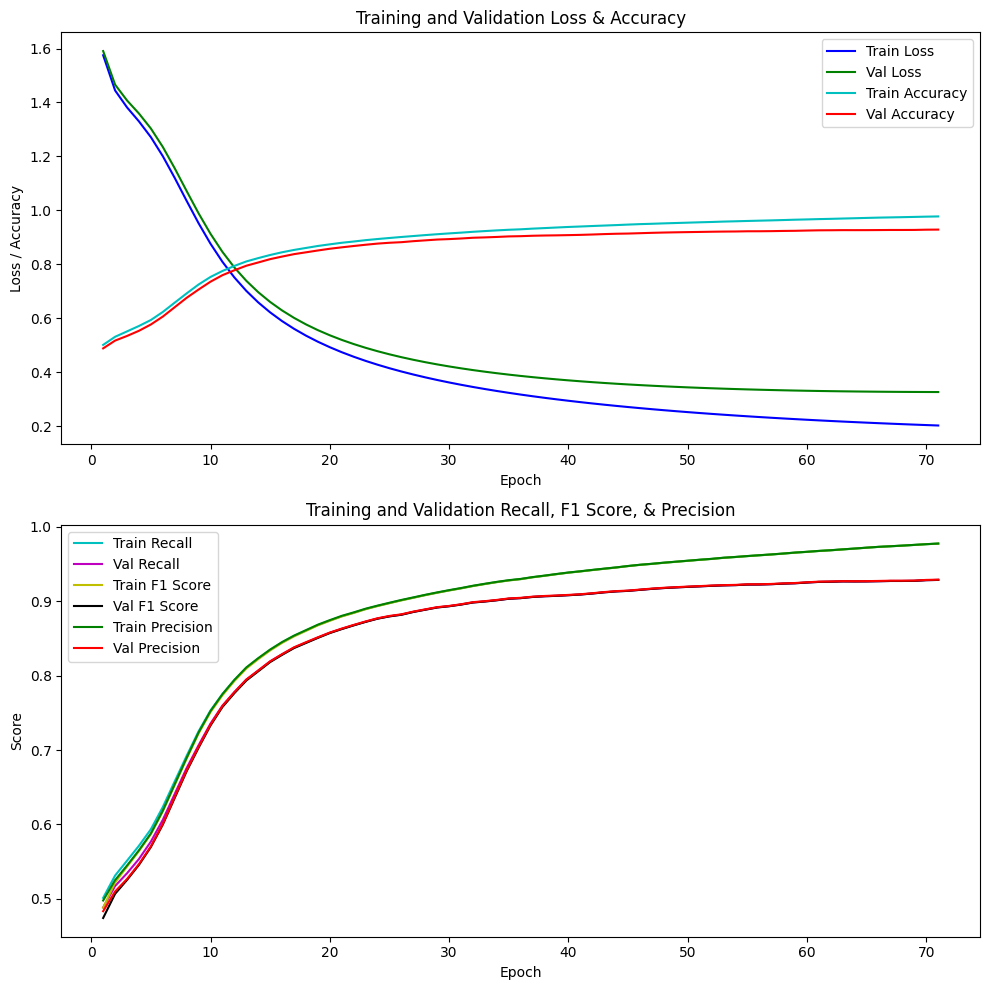

In [ ]:
evaluate_model_end( 512,
                None,
                None,
                0.00008,
                32,
                x_train,
                y_train_one_hot,
                x_val,
                y_val_one_hot,
                epochs=71,
                weight_decay=0.00001)

In [ ]:
x_train=np.concatenate([x_train, x_val])
y_train_one_hot=np.concatenate([y_train_one_hot, y_val_one_hot])
import joblib
final_model = SimpleNN(input_size=784,
                     hidden_size_layer1=512,
                     hidden_size_layer2=None,
                     hidden_size_layer3=None,
                     output_size=10,
                     learning_rate=0.00008, l2_lambda=0.00001)
num_batches = int(np.ceil(len(x_train) / 32))
for epoch in range(71):
    for i in range(num_batches):
        batch_x = x_train[i * 32:(i + 1) * 32]
        batch_y = y_train_one_hot[i * 32:(i + 1) * 32]  # Sử dụng nhãn one-hot
        final_model.train(batch_x, batch_y, 1)
joblib.dump(final_model, 'best_simple_nn_model.pkl')
print("Mô hình đã được lưu vào 'best_simple_nn_model.pkl'")

Mô hình đã được lưu vào 'best_simple_nn_model.pkl'


In [ ]:
# Tải mô hình
loaded_model = joblib.load('best_simple_nn_model.pkl')

# Sử dụng mô hình để dự đoán
test_accuracy,loss = loaded_model.evaluate(x_test, y_test_one_hot)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Loss: {loss}')

Test Accuracy: 82.95%
Loss: 0.7936883060774496
